In [1]:
# Installing DGL
! pip install  dgl -f https://data.dgl.ai/wheels/repo.html
! pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn

In [4]:
import pandas as pd
import numpy as np

In [5]:
dgl.seed(42)
torch.manual_seed(0)

In [6]:
from dgl.data.utils import load_graphs
glist, label_dict = load_graphs("./drive/MyDrive/CS6208 Project/Graph Construction/saved_graph.bin")
g = glist[0]

Adding train and test masks

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response_test.csv')

In [8]:
used_node_idx = 0
node2idx_gene = {}

gene_node_df = pd.read_csv('./drive/MyDrive/CS6208 Project/node_features/gene_node_features.csv')
for gname in set(gene_node_df['genes'].tolist()):
    # print(cl); break
    node2idx_gene[gname] = used_node_idx
    used_node_idx += 1

print("Num of unique genes: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))

Num of unique genes: 27236 | Node indices: 0 to 27235



In [9]:
used_node_idx = 0
node2idx_cellLine = {}

cell_line_nodes_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/node_features/cell_line_node_features.csv')
for cl in set(cell_line_nodes_df['ModelID'].tolist()):
    # print(cl); break
    node2idx_cellLine[cl] = used_node_idx
    used_node_idx += 1

print("Num of unique cell lines: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))

Num of unique cell lines: 1710 | Node indices: 0 to 1709



In [10]:
used_node_idx = 0
node2idx_drug = {}

drug_node_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/node_features/drug_node_features.csv')
for dname in set(drug_node_df['Name'].tolist()):
    # print(cl); break
    node2idx_drug[dname] = used_node_idx
    used_node_idx += 1

print("Num of unique drugs: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))


Num of unique drugs: 1889 | Node indices: 0 to 1888



In [11]:
from tqdm import tqdm

In [12]:
def get_train_test_edge_masks(g):
    df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response.csv')
    feat_column_list = ['AUC']
    num_feats = len(feat_column_list)

    train_mask = []

    for key, row in tqdm(df.iterrows()):
        cl = row['DepMap_ID']
        drug = row['DRUG_NAME']
        
        subset_df_train = train_df[(train_df.DepMap_ID == cl)&(train_df.DRUG_NAME == drug)]
        subset_df_test = test_df[(test_df.DepMap_ID == cl)&(test_df.DRUG_NAME == drug)]
        if len(subset_df_train) != 0:
          train_mask.append(1)
        else:
          train_mask.append(0)
    train_mask = torch.tensor(train_mask)
    test_mask = 1 - train_mask
    g.edges[('cell_line', 'response', 'drug')].data["train_mask"] = train_mask
    g.edges[('cell_line', 'response', 'drug')].data["test_mask"] = test_mask
    return g

In [13]:
g = get_train_test_edge_masks(g)

45083it [07:03, 106.47it/s]


In [14]:
# create a new heterograph with reverse edges added in
# https://discuss.dgl.ai/t/dglheterograph-how-to-add-new-edge-types-especially-reverse-edges/1408/6
def add_reverse_hetero(g):
    relations = {}
    num_nodes_dict = {ntype: g.num_nodes(ntype) for ntype in g.ntypes}
    for metapath in [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
                         ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene')]:
        # Original edges
        print(metapath)
        src, dst = g.all_edges(etype=metapath)
        relations[metapath] = (src, dst)

        reverse_metapath = (metapath[2], metapath[1] + '_by', metapath[0])
        relations[reverse_metapath] = (dst, src)           # Reverse edges

    new_g = dgl.heterograph(relations, num_nodes_dict=num_nodes_dict)

    # copy_ndata:
    for ntype in g.ntypes:
        for k, v in g.nodes[ntype].data.items():
            new_g.nodes[ntype].data[k] = v.detach().clone()

    # copy edata
    # new_g.edges[('cell_line', 'mutates', 'gene')].data["he"] = g.edges[('cell_line', 'mutates', 'gene')].data["he"]
    for e in [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
                         ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene')]:
        print(e)
        for k, v in g.edges[e].data.items():
            new_g.edges[e].data[k] = v.detach().clone()
            new_g.edges[(e[2], e[1]+ "_by", e[0])].data[k] = v.detach().clone()
        # new_g.edges[eval(f"({e[2]}, {e[1]}+ '_by', {e[0]})")].data["he"] = g.edges(e).data["he"]
        # new_g.edges[eval(e)].data["he"] = g.edges(e).data["he"]

    return new_g
    
g_with_reverse_edges = add_reverse_hetero(g)

('cell_line', 'mutates', 'gene')
('cell_line', 'response', 'drug')
('drug', 'interacts', 'drug')
('drug', 'interacts', 'gene')
('gene', 'interacts', 'gene')
('cell_line', 'mutates', 'gene')
('cell_line', 'response', 'drug')
('drug', 'interacts', 'drug')
('drug', 'interacts', 'gene')
('gene', 'interacts', 'gene')


In [15]:
g_with_reverse_edges

Graph(num_nodes={'cell_line': 1710, 'drug': 1889, 'gene': 27236},
      num_edges={('cell_line', 'mutates', 'gene'): 1183425, ('cell_line', 'response', 'drug'): 45083, ('drug', 'interacts', 'drug'): 44104, ('drug', 'interacts', 'gene'): 11370, ('drug', 'interacts_by', 'drug'): 44104, ('drug', 'response_by', 'cell_line'): 45083, ('gene', 'interacts', 'gene'): 11937785, ('gene', 'interacts_by', 'drug'): 11370, ('gene', 'interacts_by', 'gene'): 11937785, ('gene', 'mutates_by', 'cell_line'): 1183425},
      metagraph=[('cell_line', 'gene', 'mutates'), ('cell_line', 'drug', 'response'), ('gene', 'gene', 'interacts'), ('gene', 'gene', 'interacts_by'), ('gene', 'drug', 'interacts_by'), ('gene', 'cell_line', 'mutates_by'), ('drug', 'drug', 'interacts'), ('drug', 'drug', 'interacts_by'), ('drug', 'gene', 'interacts'), ('drug', 'cell_line', 'response_by')])

In [16]:
g_with_reverse_edges.nodes["cell_line"].data["hv"] = g_with_reverse_edges.nodes["cell_line"].data["hv"].to(torch.float32)
g_with_reverse_edges.nodes["drug"].data["hv"] = g_with_reverse_edges.nodes["drug"].data["hv"].to(torch.float32)
g_with_reverse_edges.nodes["gene"].data["hv"] = g_with_reverse_edges.nodes["gene"].data["hv"].to(torch.float32)

In [17]:
g_with_reverse_edges.nodes["cell_line"].data["ntype"] = torch.Tensor([0]* 1710)
g_with_reverse_edges.nodes["drug"].data["ntype"] = torch.Tensor([1]*1889)
g_with_reverse_edges.nodes["gene"].data["ntype"] = torch.Tensor([2]*27236)

In [18]:
g_with_reverse_edges.edges[('cell_line', 'mutates', 'gene')].data["etype"] = torch.Tensor([0]* 1183425) 
g_with_reverse_edges.edges[('gene', 'mutates_by', 'cell_line')].data["etype"] = torch.Tensor([1]* 1183425)  # Gene(s) -----> Cell line(t) Linear2
g_with_reverse_edges.edges[('cell_line', 'response', 'drug')].data["etype"] = torch.Tensor([2]* 45083)  # Cell line(s) -----> Drug(t) Linear3
g_with_reverse_edges.edges[('drug', 'response_by', 'cell_line')].data["etype"] = torch.Tensor([3]* 45083)  # Drug(s) -----> Cell line(t) Linear4
g_with_reverse_edges.edges[('drug', 'interacts', 'drug')].data["etype"] = torch.Tensor([4]* 44104)  # Drug(s) -----> Drug(t) Linear5
g_with_reverse_edges.edges[('drug', 'interacts_by', 'drug')].data["etype"] = torch.Tensor([4]* 44104)  # Drug(s) -----> Drug(t) Linear5
g_with_reverse_edges.edges[('drug', 'interacts', 'gene')].data["etype"] = torch.Tensor([5]* 11370)  # Drug(s) -----> Gene(t) Linear6
g_with_reverse_edges.edges[('gene', 'interacts_by', 'drug')].data["etype"] = torch.Tensor([6]* 11370)  # Gene(s) -----> Drug(t) Linear7
g_with_reverse_edges.edges[('gene', 'interacts', 'gene')].data["etype"] = torch.Tensor([7]* 11937785)  # Gene(s) -----> Gene(t) Linear8
g_with_reverse_edges.edges[('gene', 'interacts_by', 'gene')].data["etype"] = torch.Tensor([7]* 11937785) 

In [19]:
g_with_reverse_edges.edges[('cell_line', 'mutates', 'gene')].data["prev_att"] = torch.zeros(1183425, 8)
g_with_reverse_edges.edges[('gene', 'mutates_by', 'cell_line')].data["prev_att"] = torch.zeros(1183425, 8)
g_with_reverse_edges.edges[('cell_line', 'response', 'drug')].data["prev_att"] = torch.zeros(45083, 8)
g_with_reverse_edges.edges[('drug', 'response_by', 'cell_line')].data["prev_att"] = torch.zeros(45083, 8)
g_with_reverse_edges.edges[('drug', 'interacts', 'drug')].data["prev_att"] = torch.zeros(44104, 8)
g_with_reverse_edges.edges[('drug', 'interacts_by', 'drug')].data["prev_att"] = torch.zeros(44104, 8)
g_with_reverse_edges.edges[('drug', 'interacts', 'gene')].data["prev_att"] = torch.zeros(11370, 8)
g_with_reverse_edges.edges[('gene', 'interacts_by', 'drug')].data["prev_att"] = torch.zeros(11370, 8)
g_with_reverse_edges.edges[('gene', 'interacts', 'gene')].data["prev_att"] = torch.zeros(11937785, 8)
g_with_reverse_edges.edges[('gene', 'interacts_by', 'gene')].data["prev_att"] = torch.zeros(11937785, 8)

In [20]:
g_with_reverse_edges.edges[('drug', 'interacts_by', 'drug')].data['he'] = g_with_reverse_edges.edges[('drug', 'interacts', 'drug')].data['he']
g_with_reverse_edges.edges[('gene', 'interacts_by', 'gene')].data['he'] = g_with_reverse_edges.edges[('gene', 'interacts', 'gene')].data['he']

In [21]:
g_with_reverse_edges.edges[('gene', 'interacts_by', 'gene')].data['he'].to(torch.float32)
g_with_reverse_edges.edges[('drug', 'interacts_by', 'drug')].data['he'].to(torch.float32)
g_with_reverse_edges.edges[('drug', 'interacts', 'drug')].data["he"].to(torch.float32)
g_with_reverse_edges.edges[('gene', 'interacts', 'gene')].data['he'].to(torch.float32)

tensor([[155.],
        [255.],
        [153.],
        ...,
        [519.],
        [520.],
        [316.]])

In [22]:
import dgl.nn as dglnn

In [23]:
import dgl.function as fn

In [24]:
d={ 
      ('cell_line', 'mutates', 'gene'): None,
      ('gene', 'mutates_by', 'cell_line'): None,
      ('cell_line', 'response', 'drug'): None,
      ('drug', 'response_by', 'cell_line'): None,
      ('drug', 'interacts', 'drug'): 5,
      ('drug', 'interacts_by', 'drug'): 5,
      ('drug', 'interacts', 'gene'): None,
      ('gene', 'interacts', 'gene'): 1,
      ('gene', 'interacts_by', 'gene'): 1,
      ('gene', 'interacts_by', 'drug'): None,
    }

In [25]:
d[('cell_line', 'mutates', 'gene')] == None

True

In [26]:
class NodeEmbedder(nn.Module):
  r"""
  Inputs for init():
  in_feat_dim: dict of node feature dimensions
    For 0th layer:
    Eg: {"cell_line": 42, "drug": 2048, "gene": 3090}
    For any layer l, l!= 0
    Eg: {"cell_line": 32, "drug": 16, "gene": 16}
  out_feat_dim: dict of output node feature dimensions
    For 0th layer:
    Eg: {"cell_line": 32, "drug": 16, "gene": 16}
    For any layer l, l!= 0
    Eg: {"cell_line": 16, "drug": 8, "gene": 8}
  edge_feat_dim: dict of edge feature dimensions
    For all layers
    Eg: {
      ('cell_line', 'mutates', 'gene'): None, # Cell line(s) -----> Gene(t) Linear1
      ('gene', 'mutates_by', 'cell_line'): None, # Gene(s) -----> Cell line(t) Linear2
      ('cell_line', 'response', 'drug'): None, # Cell line(s) -----> Drug(t) Linear3
      ('drug', 'response_by', 'cell_line'): None, # Drug(s) -----> Cell line(t) Linear4
      ('drug', 'interacts', 'drug'): 5, # Drug(s) -----> Drug(t) Linear5
      ('drug', 'interacts_by', 'drug'): 5, # Drug(s) -----> Drug(t) Linear5
      ('drug', 'interacts', 'gene'): None, # Drug(s) -----> Gene(t) Linear6
      ('gene', 'interacts_by', 'drug'): None, # Gene(s) -----> Drug(t) Linear7
      ('gene', 'interacts', 'gene'): 1, # Gene(s) -----> Gene(t) Linear8
      ('gene', 'interacts_by', 'gene'): 1, # Gene(s) -----> Gene(t) Linear8
      }
  
  prev_att_feat_dim: dict of previous layer's attention dimensions
    For any layer l
    dimension here matches dimension of source node feature from layer l-1
    Eg: {
      ('cell_line', 'mutates', 'gene'): 32, # Cell line(s) -----> Gene(t) Linear1
      ('gene', 'mutates_by', 'cell_line'): 16, # Gene(s) -----> Cell line(t) Linear2
      ('cell_line', 'response', 'drug'): 32, # Cell line(s) -----> Drug(t) Linear3
      ('drug', 'response_by', 'cell_line'): 16, # Drug(s) -----> Cell line(t) Linear4
      ('drug', 'interacts', 'drug'): 16, # Drug(s) -----> Drug(t) Linear5
      ('drug', 'interacts_by', 'drug'): 16, # Drug(s) -----> Drug(t) Linear5
      ('drug', 'interacts', 'gene'): 16, # Drug(s) -----> Gene(t) Linear6
      ('gene', 'interacts_by', 'drug'): 16, # Gene(s) -----> Drug(t) Linear7
      ('gene', 'interacts', 'gene'): 16, # Gene(s) -----> Gene(t) Linear8
      ('gene', 'interacts_by', 'gene'): 16, # Gene(s) -----> Gene(t) Linear8
      }
  Inputs for forward():
  in_feat: dict of node features - used to infer node feature dimension
  out_feat_dim: dict of output node feature dimensions
  edge_feat: dict of edge features - used to infer edge feature dimension
  Note:
  .. math::
    a_{st}^{l} dimension = h_{s}^{l} dimension to perform dot product for attention

    a_{st}^{l} = Linear_{e}(h_{s}||h_{t}||a_{st}^{l-1}||e_{st})

  Output:
  node features h_{i} for all nodes with dimensions as described in out_feat_dim

  """
  def __init__(self, in_feat_dim, out_feat_dim, edge_feat_dim):
    super().__init__()
    # For attention calculation
    self.att_layers = []
    self.rels = []
    for k,v in edge_feat_dim.items():
      print(k)
      if (k == ('drug', 'interacts_by', 'drug')) or (k == ('gene', 'interacts_by', 'gene')): # reuse older layer
        continue
      source = k[0]
      destination = k[2]
      source_dim = in_feat_dim[source]
      destination_dim = in_feat_dim[destination]
      edge_dim = edge_feat_dim[k]
      if edge_dim == None:
        edge_dim = 0
      prev_attention_dim = source_dim # for dot product to work
      overall_in_dim = source_dim + destination_dim + edge_dim + prev_attention_dim
      overall_out_dim = source_dim
      self.att_layers.append(nn.Linear(overall_in_dim, overall_out_dim))
      self.rels.append(k)
    self.node_linear_layers = [] # Change this part for different node-edge configurations
    # self.node_linear_layers.append(nn.Linear(in_feat_dim["drug"] + in_feat_dim["gene"], out_feat_dim["cell_line"]))
    # self.node_linear_layers.append(nn.Linear(in_feat_dim["drug"] + in_feat_dim["cell_line"] + in_feat_dim["gene"], out_feat_dim["drug"]))
    # self.node_linear_layers.append(nn.Linear(in_feat_dim["drug"] + in_feat_dim["cell_line"] + in_feat_dim["gene"], out_feat_dim["gene"]))
    self.node_linear_layers.append(nn.Linear(in_feat_dim["cell_line"], in_feat_dim["cell_line"]))
    self.node_linear_layers.append(nn.Linear(in_feat_dim["drug"], in_feat_dim["drug"]))
    self.node_linear_layers.append(nn.Linear(in_feat_dim["gene"], in_feat_dim["gene"]))
    self.final_linear = []
    self.final_linear.append(nn.Linear(in_feat_dim["cell_line"], out_feat_dim["cell_line"]))
    self.final_linear.append(nn.Linear(in_feat_dim["drug"], out_feat_dim["drug"]))
    self.final_linear.append(nn.Linear(in_feat_dim["gene"], out_feat_dim["gene"]))

    
  def update_e_ij(self, edges):
    # return edge features after update
    # print(edges.src["z"].shape)
    # print(edges.dst["z"].shape)
    # print(edges.data["prev_att"].shape)
    edge_type = int(edges.data["etype"][0].detach().item())
    # print(edge_type)
    if edge_type in [0, 1, 2, 3, 5, 6]: # not gene-gene or drug-drug i.e. no edge features
      return {"e_ij": self.att_layers[edge_type]((torch.cat([edges.src['z'], edges.dst['z'], edges.data["prev_att"]], dim=1)))}
    # print(edges.data["he"].shape)
    # print(self.att_layers[edge_type])
    return {"e_ij": self.att_layers[edge_type](torch.cat([edges.src['z'], edges.dst['z'], edges.data["prev_att"], edges.data["he"]], dim=1).to(torch.float32))}

  
  def reduce_func(self, nodes):
    alpha_ij = nodes.mailbox["prev_att"]
    # print("alpha")
    # print(alpha_ij.shape)
    # if alpha_ij.dim() > 2:
    #   alpha_ij = alpha_ij.sum(dim=1).view(-1, nodes.mailbox["prev_att"].shape[-1])
    # inp = torch.cat(alpha_ij, dim=1) # combine all incoming messages
    # inp = torch.sum([alpha_ij], dim = 0)
    inp = nodes.mailbox["z"]
    ntype = int(nodes.data["ntype"][0].detach().item())
    # print("ntype")
    # print(ntype)
    # print("inp")
    # print(inp.shape)
    # print("after node linear")
    # print(self.node_linear_layers[ntype](inp).shape)
    # print((alpha_ij * self.node_linear_layers[ntype](inp)).shape)
    h = nn.LeakyReLU()(self.final_linear[ntype]((alpha_ij * self.node_linear_layers[ntype](inp)).mean(dim=1).squeeze(1)))
    
    return {"h": h}

  def message_func(self, edges):
    return {"z": edges.src["z"], "prev_att": edges.data["e_ij"]}# * edges.src["z"]}

  def forward(self, g, h):
    # do the edge and node update for each type
    with g.local_scope(): # to prevent changes from going back to the original graph
      g.ndata["z"] = h
      for et in self.rels:
        g.apply_edges(self.update_e_ij, etype=et)
      # g.update_all(self.message_func, self.reduce_func)
      # g.multi_update_all({rel: (fn.u_mul_e('z', 'e_ij', 'm'), self.reduce_func) for rel in self.rels})
      g.multi_update_all({rel: (self.message_func, self.reduce_func) for rel in self.rels}, "sum")
      # g.update_all(fn.copy_u('z', 'z'), fn.)
      # g.edata["prev_att"] = g.edata["e_ij"]

      return g.ndata["h"]

In [27]:
in_feat_dim = {"cell_line": 8, "drug": 8, "gene": 8}
out_feat_dim = {"cell_line": 4, "drug": 4, "gene": 4}
edge_feat_dim = {
      ('cell_line', 'mutates', 'gene'): None, # Cell line(s) -----> Gene(t) Linear1
      ('gene', 'mutates_by', 'cell_line'): None, # Gene(s) -----> Cell line(t) Linear2
      ('cell_line', 'response', 'drug'): None, # Cell line(s) -----> Drug(t) Linear3
      ('drug', 'response_by', 'cell_line'): None, # Drug(s) -----> Cell line(t) Linear4
      ('drug', 'interacts', 'drug'): 5, # Drug(s) -----> Drug(t) Linear5
      ('drug', 'interacts_by', 'drug'): 5, # Drug(s) -----> Drug(t) Linear5
      ('drug', 'interacts', 'gene'): None, # Drug(s) -----> Gene(t) Linear6
      ('gene', 'interacts_by', 'drug'): None, # Gene(s) -----> Drug(t) Linear7
      ('gene', 'interacts', 'gene'): 1, # Gene(s) -----> Gene(t) Linear8
      ('gene', 'interacts_by', 'gene'): 1, # Gene(s) -----> Gene(t) Linear8
      }

In [28]:
class CellLineDrugLinkPredictor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.W = nn.Linear(in_dim, 1)

    def apply_edges(self, edges):
        print(edges.src['h'].shape)
        print(edges.dst['h'].shape)
        x = torch.cat([edges.src['h'].view(edges.src["h"].shape[0], -1), edges.dst['h'].view(edges.dst["h"].shape[0], -1)], 1)
        y = nn.Sigmoid()(self.W(x))
        return {'score': y}

    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the RGCN above.
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            # print(h.shape)
            # graph.apply_edges(fn.u_dot_v('hv', 'hv', 'score'), etype=etype)
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edges[etype].data['score']

In [29]:
class Model(nn.Module):
    def __init__(self, in_feat_dim, out_feat_dim, edge_feat_dim, in_features):
        super().__init__()
        self.ne = NodeEmbedder(in_feat_dim, out_feat_dim, edge_feat_dim)
        combined_features = out_feat_dim["cell_line"] + out_feat_dim["drug"]
        print(combined_features)
        self.pred = CellLineDrugLinkPredictor(combined_features)
        self.cell_line_node_feature_converter = nn.Linear(g.nodes["cell_line"].data["hv"].shape[1], in_features)
        self.gene_node_feature_converter = nn.Linear(g.nodes["gene"].data["hv"].shape[1], in_features)
        self.drug_node_feature_converter = nn.Linear(g.nodes["drug"].data["hv"].shape[1], in_features)

    def forward(self, g, etype):
        # Convert all node features to the same size
        cl_node_features = self.cell_line_node_feature_converter(g.nodes["cell_line"].data["hv"])
        gene_node_features = self.gene_node_feature_converter(g.nodes["gene"].data["hv"])
        drug_node_features = self.drug_node_feature_converter(g.nodes["drug"].data["hv"])
        x = {"cell_line": cl_node_features, "gene": gene_node_features, "drug": drug_node_features}
        h = self.ne(g, x)
        
        return self.pred(g, h, etype)

In [49]:
m = Model(in_feat_dim, out_feat_dim, edge_feat_dim, 8)

('cell_line', 'mutates', 'gene')
('gene', 'mutates_by', 'cell_line')
('cell_line', 'response', 'drug')
('drug', 'response_by', 'cell_line')
('drug', 'interacts', 'drug')
('drug', 'interacts_by', 'drug')
('drug', 'interacts', 'gene')
('gene', 'interacts_by', 'drug')
('gene', 'interacts', 'gene')
('gene', 'interacts_by', 'gene')
8


In [50]:
# g_with_reverse_edges.nodes["cell_line"].data["hv"].shape

In [51]:
# m.cell_line_node_feature_converter

In [52]:
# g_updated = m(g_with_reverse_edges, ('cell_line', 'response', 'drug'))

In [53]:
# g_updated

In [54]:
opt = torch.optim.Adam(m.parameters(), lr=1e-3)
train_idx = g_with_reverse_edges.edges[('cell_line', 'response', 'drug')].data['train_mask'].nonzero().view(-1)
label = g_with_reverse_edges.edges[('cell_line', 'response', 'drug')].data['he']
for epoch in range(15):
    pred = m(g_with_reverse_edges, ('cell_line', 'response', 'drug'))
    # print((pred < 0).sum())
    loss = ((pred.view(-1)[train_idx] - label.view(-1)[train_idx]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

torch.Size([45083, 4])
torch.Size([45083, 4])
0.23621302753736012
torch.Size([45083, 4])
torch.Size([45083, 4])
0.21574396089549117
torch.Size([45083, 4])
torch.Size([45083, 4])
0.19105565069784755
torch.Size([45083, 4])
torch.Size([45083, 4])
0.1582263146426002
torch.Size([45083, 4])
torch.Size([45083, 4])
0.11430713541502942
torch.Size([45083, 4])
torch.Size([45083, 4])
0.07710938314369503
torch.Size([45083, 4])
torch.Size([45083, 4])
0.05455770438948459
torch.Size([45083, 4])
torch.Size([45083, 4])
0.045497636348379465
torch.Size([45083, 4])
torch.Size([45083, 4])
0.04303910178018048
torch.Size([45083, 4])
torch.Size([45083, 4])
0.042995593845774366
torch.Size([45083, 4])
torch.Size([45083, 4])
0.04367371723793295
torch.Size([45083, 4])
torch.Size([45083, 4])
0.04441007805186938
torch.Size([45083, 4])
torch.Size([45083, 4])
0.0449956552280878
torch.Size([45083, 4])
torch.Size([45083, 4])
0.04541208913230693
torch.Size([45083, 4])
torch.Size([45083, 4])
0.04569584123953037


In [55]:
test_idx = g_with_reverse_edges.edges[('cell_line', 'response', 'drug')].data['test_mask'].nonzero().view(-1)
test_preds = m(g_with_reverse_edges, ('cell_line', 'response', 'drug')).view(-1)[test_idx]

torch.Size([45083, 4])
torch.Size([45083, 4])


In [56]:
nn.MSELoss()(test_preds, label.view(-1)[test_idx])

tensor(0.0391, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [57]:
from scipy.stats import pearsonr, spearmanr
spearmanr(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy())

SignificanceResult(statistic=-0.13630940883013856, pvalue=8.529229274440063e-45)

In [58]:
pearsonr(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy())

PearsonRResult(statistic=-0.10289467431635829, pvalue=3.731877284703686e-26)

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'actual preds')

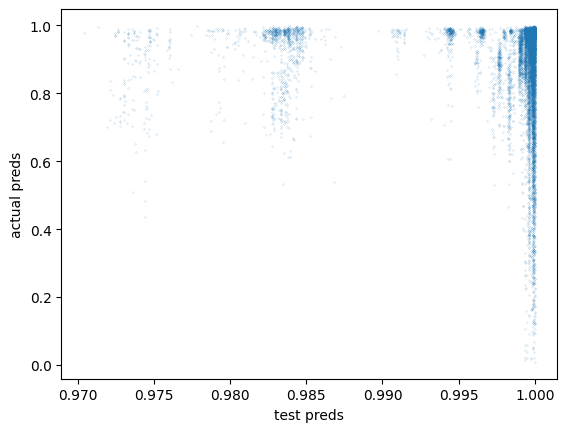

In [60]:
plt.scatter(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy(), s=0.01)
plt.xlabel("test preds")
plt.ylabel("actual preds")